In [48]:
import sys
import os
import argparse
import logging
import math

import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from dtaidistance import dtw

In [24]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
def size_cond(size):
    n = size
    r = 2
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

In [12]:
list(range(5, -1, -1))

[5, 4, 3, 2, 1, 0]

In [41]:
def create_tree(to_merge, series, linearize=True):
    clusters = {}
    for i, merge in enumerate(to_merge):
        if merge[0] <= len(to_merge):
            # if it is an original point read it from the centers array
            a = series[int(merge[0]) - 1]
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]

        if merge[1] <= len(to_merge):
            b = series[int(merge[1]) - 1]
        else:
            b = clusters[int(merge[1])]
        
        if linearize:
            clusters[1 + i + len(to_merge)] = [a, b]
        else:
            # the clusters are 1-indexed by scipy
            clusters[1 + i + len(to_merge)] = {
                'children' : [a, b]
            }
        # ^ you could optionally store other info here (e.g distances)
    
    return clusters

Distance matrix:
[[       inf 0.         2.44948974 4.35889894 5.47722558]
 [       inf        inf 2.44948974 4.35889894 5.47722558]
 [       inf        inf        inf 3.60555128 3.74165739]
 [       inf        inf        inf        inf 2.23606798]
 [       inf        inf        inf        inf        inf]]
[[0.         1.         0.         2.        ]
 [3.         4.         2.23606798 2.        ]
 [2.         5.         2.44948974 3.        ]
 [6.         7.         5.47722558 5.        ]]


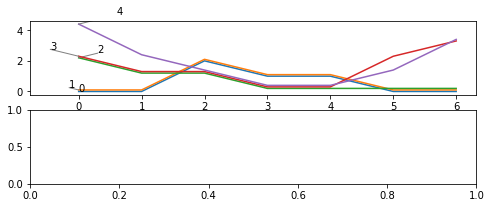

In [51]:
series = np.array([
    np.array([0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0]),
    np.array([0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0]),
    np.array([2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]),
    np.array([2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 3.0]),
    np.array([4.0, 2.0, 1.0, 0.0, 0.0, 1.0, 3.0])
])

dists = dtw.distance_matrix_fast(series)
print("Distance matrix:\n{}".format(dists))

dists_cond = np.zeros(size_cond(len(series)))
idx = 0
for r in range(len(series)-1):
    dists_cond[idx:idx+len(series)-r-1] = dists[r, r+1:]
    idx += len(series)-r-1

z = linkage(dists_cond, method='complete', metric='euclidean')
print(z)

fig, axes = plt.subplots(2, 1, figsize=(8, 3))
for idx, currentSeries in enumerate(series):
    serie = currentSeries.copy()
    serie += idx * 0.1
    axes[0].plot(serie, label=str(idx))
    axes[0].text(0 + 0.15 * (-1)**idx * idx, serie[0] + 0.15 * idx, idx)
    axes[0].add_line(Line2D([0, 0 + 0.15 * (-1)**idx * idx], [serie[0], serie[0] + 0.15 * idx],
                            linewidth=1, color='gray'))

# Select optimal cut-off point

In [52]:
axes[0].legend(loc=1)
dendrogram(z, ax=axes[1])
plt.show(block=True)

print (series)
tree = create_tree(z, series)
pp.pprint (tree)

cut = cut_tree(z)
pp.pprint(cut)

[[0. 0. 2. 1. 1. 0. 0.]
 [0. 0. 2. 1. 1. 0. 0.]
 [2. 1. 1. 0. 0. 0. 0.]
 [2. 1. 1. 0. 0. 2. 3.]
 [4. 2. 1. 0. 0. 1. 3.]]
{   5: [   array([4., 2., 1., 0., 0., 1., 3.]),
           array([0., 0., 2., 1., 1., 0., 0.])],
    6: [   array([2., 1., 1., 0., 0., 0., 0.]),
           array([2., 1., 1., 0., 0., 2., 3.])],
    7: [   array([0., 0., 2., 1., 1., 0., 0.]),
           [   array([4., 2., 1., 0., 0., 1., 3.]),
               array([0., 0., 2., 1., 1., 0., 0.])]],
    8: [   [   array([2., 1., 1., 0., 0., 0., 0.]),
               array([2., 1., 1., 0., 0., 2., 3.])],
           [   array([0., 0., 2., 1., 1., 0., 0.]),
               [   array([4., 2., 1., 0., 0., 1., 3.]),
                   array([0., 0., 2., 1., 1., 0., 0.])]]]}
array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [2, 1, 1, 0, 0],
       [3, 2, 2, 1, 0],
       [4, 3, 2, 1, 0]])


In [99]:
from scipy.spatial.distance import pdist, squareform
from dtaidistance import dtw_visualisation

In [148]:
def compute_wcss(linkage_matrix, series, euclidean_distance=False, verbose=True):
    wcss = []
    cut = np.array(cut_tree(linkage_matrix))
    for num_clusters in range(cut.shape[1]):
        current_cut = cut[:, num_clusters]
        
        num_clusters = cut.shape[1] - num_clusters
        if verbose:
            print("Selecting %d as number of clusters" % (num_clusters))
        
        if len(np.unique(current_cut)) != num_clusters:
            print("Error: Values not equal [", np.unique(current_cut), num_clusters, "]")
            exit(-1)
        
        current_wcss = 0.0
        if num_clusters != cut.shape[1]: # If every point is not assigned a separate cluster (WCSS = 0.0)
            for cluster in range(num_clusters):
                # Get all points with that particular cluster
                matches = current_cut == cluster
                points = series[matches]
                if verbose:
                    print("Number of clusters:", num_clusters, "| Matches:", matches, "| Points:", points.shape)
                
                if len(points) > 1:
                    if verbose:
                        print("Computing distance matrix")
                    
                    if euclidean_distance:
                        dist_mat = pdist(points)
                        current_wcss += np.mean(dist_mat)
                    else:
                        dist_mat = np.array(dtw.distance_matrix_fast(points))
                        dist_mat = np.triu(dist_mat, k=1)
                        current_wcss_sum = np.sum(dist_mat)
                        n = dist_mat.shape[0]
                        normalizer = ((n * (n - 1)) / 2.0)
                        if verbose:
                            print("Normalizer:", normalizer)
                        current_wcss += (current_wcss_sum / float(normalizer))
                    if verbose:
                        print("Distance matrix:", dist_mat)
                        #dtw_visualisation.plot_matrix(dist_mat, shownumbers=True)

            current_wcss = current_wcss
        wcss.append(current_wcss)

    return wcss

#                         if n > 1:
#                             normalizer = ((n * (n - 1)) / 2.0)
#                             if verbose:
#                                 print("Normalizer:", normalizer)
#                             current_wcss += (current_wcss_sum / float(normalizer))
#                         else:
#                             current_wcss += current_wcss_sum

In [149]:
compute_wcss(z, series)

Selecting 5 as number of clusters
Selecting 4 as number of clusters
Number of clusters: 4 | Matches: [ True  True False False False] | Points: (2, 7)
Computing distance matrix
Normalizer: 1.0
Distance matrix: [[0. 0.]
 [0. 0.]]
Number of clusters: 4 | Matches: [False False  True False False] | Points: (1, 7)
Number of clusters: 4 | Matches: [False False False  True False] | Points: (1, 7)
Number of clusters: 4 | Matches: [False False False False  True] | Points: (1, 7)
Selecting 3 as number of clusters
Number of clusters: 3 | Matches: [ True  True False False False] | Points: (2, 7)
Computing distance matrix
Normalizer: 1.0
Distance matrix: [[0. 0.]
 [0. 0.]]
Number of clusters: 3 | Matches: [False False  True False False] | Points: (1, 7)
Number of clusters: 3 | Matches: [False False False  True  True] | Points: (2, 7)
Computing distance matrix
Normalizer: 1.0
Distance matrix: [[0.         2.23606798]
 [0.         0.        ]]
Selecting 2 as number of clusters
Number of clusters: 2 | 

[0.0, 0.0, 2.23606797749979, 3.8690611393552414, 3.4154505162488746]

In [150]:
compute_wcss(z, series, euclidean_distance=True)

Selecting 5 as number of clusters
Selecting 4 as number of clusters
Number of clusters: 4 | Matches: [ True  True False False False] | Points: (2, 7)
Computing distance matrix
Distance matrix: [0.]
Number of clusters: 4 | Matches: [False False  True False False] | Points: (1, 7)
Number of clusters: 4 | Matches: [False False False  True False] | Points: (1, 7)
Number of clusters: 4 | Matches: [False False False False  True] | Points: (1, 7)
Selecting 3 as number of clusters
Number of clusters: 3 | Matches: [ True  True False False False] | Points: (2, 7)
Computing distance matrix
Distance matrix: [0.]
Number of clusters: 3 | Matches: [False False  True False False] | Points: (1, 7)
Number of clusters: 3 | Matches: [False False False  True  True] | Points: (2, 7)
Computing distance matrix
Distance matrix: [2.44948974]
Selecting 2 as number of clusters
Number of clusters: 2 | Matches: [ True  True  True False False] | Points: (3, 7)
Computing distance matrix
Distance matrix: [0.         2

[0.0, 0.0, 2.449489742783178, 4.335107825947305, 3.6239155296934706]

# Test with internal lib

In [ ]:
from dtaidistance import clustering

In [117]:
# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
# Augment Hierarchical object to keep track of the full tree
model2 = clustering.HierarchicalTree(model1)
# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(series)

In [118]:
print(cluster_idx)

None


In [119]:
model3

In [124]:
model2.fit(series)

 80%|████████  | 4/5 [00:00<00:00, 2942.34it/s]


{0: {0, 1, 2, 3, 4}}

In [121]:
model2

In [122]:
model3.fit(series)

In [123]:
model1.fit(series)

 80%|████████  | 4/5 [00:00<00:00, 2104.25it/s]


{0: {0, 1, 2, 3, 4}}

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f632a4d47f0>,
       dtype=object))

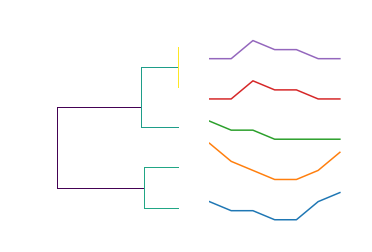

In [129]:
model3.plot("myplot.png")

In [130]:
help(model3)

Help on LinkageTree in module dtaidistance.clustering object:

class LinkageTree(BaseTree)
 |  Hierarchical clustering using the Scipy linkage function.
 |  
 |  This is the same but faster algorithm as available in Hierarchical (~10 times faster). But with less
 |  options to steer the clustering (e.g. no possibility to give weights). It still computes the entire
 |  distance matrix first and is thus not ideal for extremely large data sets.
 |  
 |  Method resolution order:
 |      LinkageTree
 |      BaseTree
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dists_fun, dists_options)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, series)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from BaseTree:
 |  
 |  get_linkage(self, node)
 |  
 |  plot(self, filename=None, axes=None, ts_height=10, bottom_margin=2, top_margin=2, ts_left_margin=0, ts_sample_length=1, t

In [132]:
z = model3.get_linkage()
print(z)

TypeError: get_linkage() missing 1 required positional argument: 'node'

In [135]:
ds = dtw.distance_matrix_fast(series)
print(ds) # Only upper triangular matrix is useful

[[       inf 0.         2.44948974 4.35889894 5.47722558]
 [       inf        inf 2.44948974 4.35889894 5.47722558]
 [       inf        inf        inf 3.60555128 3.74165739]
 [       inf        inf        inf        inf 2.23606798]
 [       inf        inf        inf        inf        inf]]


# Visualization

In [141]:
from dtaidistance import dtw_visualisation

In [140]:
import dtaidistance
help(dtaidistance)

Help on package dtaidistance:

NAME
    dtaidistance

DESCRIPTION
    dtaidistance
    ~~~~~~~~~~~~
    
    Time series distance methods.
    
    :author: Wannes Meert
    :copyright: Copyright 2017 KU Leuven, DTAI Research Group.
    :license: Apache License, Version 2.0, see LICENSE for details.

PACKAGE CONTENTS
    clustering
    dtw
    dtw_c
    dtw_ndim
    dtw_visualisation
    dtw_weighted
    util

DATA
    __copyright__ = 'Copyright 2017-2018 KU Leuven, DTAI Research Group'
    __license__ = 'Apache License, Version 2.0'
    logger = <Logger be.kuleuven.dtai.distance (WARNING)>

VERSION
    1.1.3

AUTHOR
    Wannes Meert

FILE
    /home/siddiqui/anaconda3/lib/python3.6/site-packages/dtaidistance/__init__.py




(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6329d6e908>)

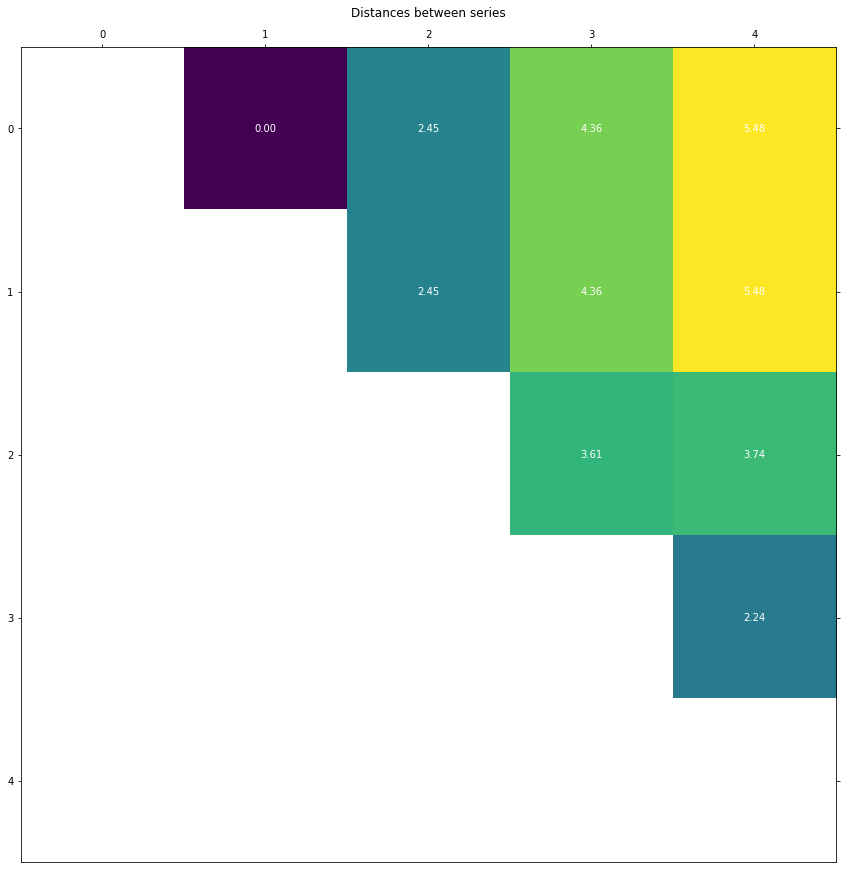

In [143]:
dtw_visualisation.plot_matrix(ds, shownumbers=True)

# Test

In [151]:
size_cond(32)

495

In [152]:
f = math.factorial

In [159]:
cond = lambda n: int(f(n) / (f(n-2) * f(2)))

In [160]:
cond(32)

496